In [4]:
 
%run "affine gap seq al.ipynb""

2021-08-02 22:50:39,677 [10984] WARNING  py.warnings:110: [JupyterRequire] C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,

2021-08-02 22:50:39,677 [10984] WARNING  py.warnings:110: [JupyterRequire] C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.

In [5]:
#someday i'll fix env in my pc, but not today
import warnings
warnings.filterwarnings("ignore")

In [6]:
FAM_FILE_PATH  = "D://bio_inf//annotation//our_families.out" 
TEST_FILE_PATH = "D://bio_inf//annotation//genbank//ncbi-genomes-2021-07-24//GCA_000427115.1_CBEV_1_genomic.gbff.gz" #"C://Users//Artem//Downloads//GCA_000864765.1_ViralProj15476_genomic.gbff"
TEST_FILE_GFF_PATH = "C://Users//Artem//Downloads//GCA_000864765.1_ViralProj15476_genomic.gff"
GENBANK_GFF_DIR = "D://bio_inf//annotation//genbank_gff//ncbi-genomes-2021-07-24//"
GENBANK_FASTA_DIR = "D://bio_inf//annotation//genbank_fasta//"
SPLICE_DATASET_DIR = "D://bio_inf//annotation//splice_dataset//"
PROKKA_OUT_DIR = "D://bio_inf//annotation//splice_dataset_prokka_out//"
MODIFIED_PROKKA_OUT_DIR = "D://bio_inf//annotation//modified_prokka_out//"
annotations_list_gff = glob.glob(GENBANK_GFF_DIR + "*")

In [8]:
fam_file = open(FAM_FILE_PATH, "r")
fams = fam_file.read().split()

In [5]:
def create_fam_folders(path, fams):
    for f in fams:
        if not os.path.exists(path + f):
            os.mkdir(path + f)
create_fam_folders(SPLICE_DATASET_DIR, fams)

In [6]:
gffutils.__version__

'0.10.1'

In [2]:
%run "parsing_functions.ipynb"

def families_split(db:"parsed gbff file",  name:"file name no path", origin_folder, families_folder, families_list): 
    #move all suitable gff files into fam folders
    taxon = db[0].annotations["taxonomy"]
    count = 0
    for t in taxon:
        if t in families_list:
            #print(t)
            count += 1
            if count > 1: 
                print(name)
            #shutil.copy(origin_folder + name, families_folder + t + "//" + name)

            
def parse_compare_annotations(vir_name, path_to_prokka_out, path_to_annotation, family = "*"):
    #print(vir_name)
    family = family + "//"
    annot_expr = path_to_annotation + family + vir_name + "*.gff*"
    prokka_expr = path_to_prokka_out + family + vir_name + "//" + vir_name + "*gff"
    annot_cands = glob.glob(annot_expr)
    prokka_cands = glob.glob(prokka_expr)
    if len(annot_cands) != 1 or len(prokka_cands) != 1:
        print(colored("PARSING ERROR","red"))
        print(annot_expr, annot_cands)
        print(prokka_expr, prokka_cands)
    #print(len(annot_cands), len(prokka_cands))
    ant = parsegff(annot_cands[0])
    try:
        prk = parsegff(prokka_cands[0])
        return ant, prk
    except:
        return ant, None

%run "print_functions.ipynb""      
        
class annot_stats:
    def __init__(self): 
        self.tp, self.tn, self.fp, self.fn = 0,0,0,0
        self.correct_starts, self.correct_stops = 0,0
        self.correct_percentage_predict, self.incorrect_percentage_predict = 0,0
        
    def __repr__(self):
        ans = ""
        ans += print_to_string("Tp:", self.tp, "Fp:", self.fp, "Fn:", self.fn)
        ans += print_to_string("Precision:", self.tp/(self.tp + self.fp), "Recall:", self.tp/(self.tp + self.fn),"F-score:", self.tp/(self.tp + 0.5*(self.fp + self.fn)))
        ans += print_to_string("Correct starts:", self.correct_starts, "Correct stops:", self.correct_stops)
        ans += print_to_string("Correct percentage predict:", self.correct_percentage_predict, 
               "Incorrect percentage predict:", self.incorrect_percentage_predict)
        return ans

def check_order(x):
    if x[0] > x[1]:
        print(colored("UNORDERED GENE", "red"))

def percentage_predict(first_coords, second_coords):
    cutoff = 0.8
    check_order(first_coords)
    check_order(second_coords)
    if first_coords[2] != second_coords[2] or first_coords[3] != second_coords[3]:
        return False
    if first_coords[0] > second_coords[0]:
        first_coords, second_coords = second_coords, first_coords
    if first_coords[1] < second_coords[0]:
        return False
    intersection_length = first_coords[1] - second_coords[0]
    if (intersection_length/(first_coords[1] - first_coords[0]) >= cutoff) and (intersection_length/(second_coords[1] - second_coords[0]) >= cutoff):
        return True
    return False

def calculate_stats_from_annotations(reference_annotation, prokka_annotation, 
                                     stats_database:"used to store results of stats calculation" = None, supress_output = False):
    an_cds = list(reference_annotation.features_of_type('CDS')) 
    if prokka_annotation == None:
        pr_cds = []
    else:
        pr_cds = list(prokka_annotation.features_of_type('CDS'))
    
    #calculate general stats
    sprint("Annotation quantity:", len(an_cds), "Prokka quantity:", len(pr_cds), supress_output=supress_output)
    
    #number of fp tp and vice versa 
    annot_intervals = [(e.start, e.stop) for e in an_cds]
    annot_intervals_with_frame_info = [(e.start, e.stop, e.frame, e.strand) for e in an_cds]
    annot_starts = [e.start for e in an_cds]
    annot_stops = [e.stop for e in an_cds]
    prokka_intervals = [(e.start, e.stop) for e in pr_cds]
    prokka_intervals_with_frame_info = [(e.start, e.stop, e.frame, e.strand) for e in pr_cds]
    prokka_starts = [e.start for e in pr_cds]
    prokka_stops = [e.stop for e in pr_cds]
    tp, tn, fp, fn = 0,0,0,0
    for anin in annot_intervals:
        if anin in prokka_intervals:
            tp += 1
        else:
            fn += 1
    for prin in prokka_intervals:
        if prin not in annot_intervals:
            fp += 1
    prc = 0
    if (tp + fp) != 0:
        prc = tp/(tp + fp)
    rcl = 0
    if (tp + fn) != 0:
        rcl = tp/(tp + fn)
    fscr = 0
    if (tp + 0.5*(fp + fn)) != 0:
        fscr = tp/(tp + 0.5*(fp + fn))
    sprint("Precision:", prc, "Recall:", rcl,"F-score:", fscr,supress_output=supress_output)
    
    
    #need to calculate more advanced stats like number of correct starts, correct finishes, 
    #number of genes predicted by more than 80 percent
    correct_starts = sum([e in prokka_starts for e in annot_starts])
    correct_stops = sum([e in prokka_stops for e in annot_stops])
    
    correct_percentage_predict = 0
    incorrect_percentage_predict = 0
    
    for anint in annot_intervals_with_frame_info:
        perc_predicted = False
        for prkint in prokka_intervals_with_frame_info:
            if percentage_predict(prkint, anint):
                perc_predicted = True
                break
        if not perc_predicted:
            incorrect_percentage_predict += 1
        else:
            correct_percentage_predict += 1
    
    sprint("Correct starts:", correct_starts, "Correct stops:", correct_stops, supress_output=supress_output)
    sprint("Correct percentage predict:", correct_percentage_predict, 
           "Incorrect percentage predict:", incorrect_percentage_predict, supress_output=supress_output)
    
    
    
    #gather stats
    if stats_database != None:
        stats_database.tp += tp
        stats_database.tn += tn
        stats_database.fp += fp
        stats_database.fn += fn
        stats_database.correct_starts += correct_starts
        stats_database.correct_stops += correct_stops
        stats_database.correct_percentage_predict += correct_percentage_predict
        stats_database.incorrect_percentage_predict += incorrect_percentage_predict



a = parsegb(TEST_FILE_PATH)

a_gff = parsegff(TEST_FILE_GFF_PATH)

NameError: name 'TEST_FILE_PATH' is not defined

In [1]:
#some functions for gene stats

#all that was here now in kmer_functions
%run "kmer_functions.ipynb"

In [9]:




def get_all_the_genes_of_family(fam):
    
    genes = []
    annots = []
    if type(fam) == list:
        for f in fam:
            g_t, a_t = get_all_the_genes_of_family(f)
            genes += g_t
            annots += a_t
        return genes, annots
    virs = os.listdir(SPLICE_DATASET_DIR + fam)
    for v in long_wrap(virs):
        gff_file = parsegff(SPLICE_DATASET_DIR + fam + "//" + v)
        vir_name = ".".join(v.split(".")[:2])
        fasta_file = parsefasta(GENBANK_FASTA_DIR + vir_name + ".fna.gz")
        #print(dir(fasta_file))
        feats = gff_file.features_of_type("CDS")
        #print(fasta_file)
        for f in feats:
            beg = f.start
            end = f.stop
            genes.append(find_by_id(fasta_file, f.seqid).seq[beg - 1: end])
            annots.append(f)
    return genes, annots

def get_all_the_genomes_of_family(fam):
    
    genomes = []
    if type(fam) == list:
        for f in fam:
            g_t = get_all_the_genomes_of_family(f)
            genomes += g_t
        return genomes
    virs = os.listdir(SPLICE_DATASET_DIR + fam)
    for v in long_wrap(virs):
        #gff_file = parsegff(SPLICE_DATASET_DIR + fam + "//" + v)
        vir_name = ".".join(v.split(".")[:2])
        fasta_file = parsefasta(GENBANK_FASTA_DIR + vir_name + ".fna.gz")
        #feats = gff_file.features_of_type("CDS")
        for f in fasta_file:
            genomes.append(f.seq)
    return genomes

In [10]:
[1,2] + [1,2]

[1, 2, 1, 2]

In [11]:
tombus_genes, tombus_annots = get_all_the_genes_of_family(["Reoviridae"])
tombus_strings = [str(e) for e in tombus_genes]
tombus_genomes = get_all_the_genomes_of_family(["Reoviridae"])
#tombus_genomes_strings = [str(e) for e in tombus_genomes]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3066/3066 [00:01<00:00, 2204.16it/s]


In [129]:
len(tombus_genomes)

33198

In [130]:
genome_stats = [dict() for i in range(1,7)]
for genome in tqdm.tqdm(tombus_genomes):
    genome_stats = [dict_add(*e) for e in zip(genome_stats, calculate_kmers(genome))]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33198/33198 [17:02<00:00, 32.46it/s]


In [132]:
gene_stats = [dict() for i in range(1,7)]
for gene in tqdm.tqdm(tombus_genes):
    gene_stats = [dict_add(*e) for e in zip(gene_stats, calculate_kmers(gene))]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34548/34548 [16:03<00:00, 35.85it/s]


In [136]:
dif_stats = compare_kmers(genome_stats, gene_stats)

In [137]:
dif_stats_norm = [dict_multiply_constant(e, len(e.values())) for e in dif_stats]

In [141]:
'''tmp_out_file = "reoviridae_tmp.out"
a = open(tmp_out_file, "w")
for val in range(1,7):
    t_l = sorted(list(zip(dif_stats_norm[val - 1].values(), dif_stats_norm[val - 1].keys())))
    for el in t_l:
        a.write(print_to_string(*el))
        
a.close()'''

In [140]:
len(dif_stats_norm)

6

In [138]:
val = 4
sorted(list(zip(dif_stats_norm[val].values(), dif_stats_norm[val].keys())))

[(-0.11232425326126405, 'CAAAT'),
 (-0.11098315015182658, 'TGGAT'),
 (-0.1025658531621243, 'ATGCA'),
 (-0.0987628094626074, 'TTCAA'),
 (-0.09641391054195747, 'TCAAA'),
 (-0.09082201904437914, 'ATTGG'),
 (-0.09080215309725892, 'TATTG'),
 (-0.09071146880726744, 'AAATT'),
 (-0.08934683849177061, 'CAATT'),
 (-0.08794786540321642, 'GAAAA'),
 (-0.08744408003228443, 'ATCAA'),
 (-0.08723485588608204, 'AATAA'),
 (-0.0869081939409666, 'AAATA'),
 (-0.08256316465901836, 'AAATG'),
 (-0.08127576892459754, 'ATGAA'),
 (-0.08019602717604091, 'TGCAG'),
 (-0.07958684885075429, 'TACAT'),
 (-0.07914168874758332, 'ATGGA'),
 (-0.0789337137205548, 'AAAAT'),
 (-0.07860719853059628, 'AGAAA'),
 (-0.07610765192059699, 'GATTT'),
 (-0.07579370891761084, 'AATTG'),
 (-0.07312950334644785, 'AATAT'),
 (-0.07276022004145566, 'TCGAA'),
 (-0.07233739695782315, 'ATTCA'),
 (-0.06929172871378242, 'ATTTA'),
 (-0.06905963370631163, 'ACAAA'),
 (-0.06881897797157888, 'CAGTT'),
 (-0.06858031364603834, 'GAAAT'),
 (-0.0673181111334

In [96]:
val = 4
sorted(list(zip(dif_stats_norm[val].values(), dif_stats_norm[val].keys())))

[(-0.4464309354548446, 'GAGGA'),
 (-0.30719193145182655, 'TCAAG'),
 (-0.2753136314651865, 'GGAGG'),
 (-0.2496821314668698, 'AAGAA'),
 (-0.24242828235438862, 'CAAGG'),
 (-0.22935071468255175, 'AGGAG'),
 (-0.21123525895946083, 'GAAGA'),
 (-0.2000317690331277, 'AAGGA'),
 (-0.1948335609507501, 'TCGAG'),
 (-0.183145524775417, 'ATGGA'),
 (-0.183004749292472, 'AGGAA'),
 (-0.1805062935401891, 'AAGAG'),
 (-0.17784676277665, 'GAGCT'),
 (-0.16503101277749166, 'GAGGC'),
 (-0.1639222772667457, 'GGAAG'),
 (-0.16229028390070876, 'TTCAA'),
 (-0.16204857701130826, 'TGAGG'),
 (-0.16142438774956203, 'ATTCG'),
 (-0.15721274051799838, 'CGAGG'),
 (-0.15439175725313736, 'GACGA'),
 (-0.1520342657288325, 'CGAAG'),
 (-0.15116723710748703, 'ATCAA'),
 (-0.1475405012962796, 'AAGGC'),
 (-0.14639173296401076, 'TGCTG'),
 (-0.14488040429764126, 'GAGGT'),
 (-0.14347000703772728, 'CTCAA'),
 (-0.1360945495004131, 'CAAGA'),
 (-0.13389851047743062, 'TCAAA'),
 (-0.1333543868587297, 'ATGGC'),
 (-0.13226670585642708, 'CTCGA')

In [11]:
distance_matrix = [[Levenshtein.distance(x,y) for x in tombus_strings] for y  in tqdm.tqdm(tombus_strings)]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 533/533 [06:34<00:00,  1.35it/s]


In [12]:

distance_matrix = np.array(distance_matrix)
distance_matrix_norm = distance_matrix/np.mean(distance_matrix)

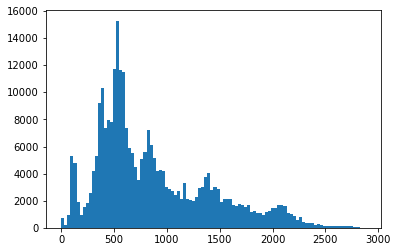

In [13]:
plt.hist(distance_matrix.reshape(-1), bins = 100);

In [14]:


dbscan = DBSCAN(min_samples=30, eps = 0.7).fit(distance_matrix)

In [15]:
unique, counts = np.unique(dbscan.labels_, return_counts=True)
print(dict(zip(unique, counts))[-1])

533


In [16]:
X_embedded = TSNE(n_components=2).fit_transform(distance_matrix)
X_embedded.shape

(533, 2)

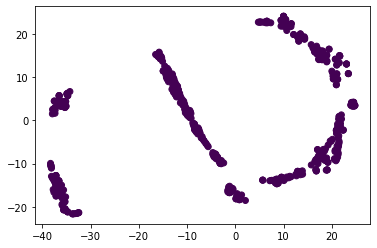

In [17]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], c = dbscan.labels_)

In [18]:
np.unique(dbscan.labels_, return_counts=True)

(array([-1], dtype=int64), array([533], dtype=int64))

In [19]:
tombus_strings = np.array(tombus_strings)
tombus_annots = np.array(tombus_annots)
tombus_selected_by_labels = [tombus_annots[dbscan.labels_ == e] for e in np.unique(dbscan.labels_)]

In [154]:
fs = tombus_selected_by_labels[2]
for feat in fs:
    #print(dir(feat))
    print(feat.attributes)
    print()
    

ID: ['cds-BAB62819.1']
Parent: ['gene-ORF1']
Dbxref: ['NCBI_GP:BAB62819.1']
Name: ['BAB62819.1']
gbkey: ['CDS']
gene: ['ORF1']
product: ['replicase']
protein_id: ['BAB62819.1']

ID: ['cds-BAB62822.1']
Parent: ['gene-ORF4']
Dbxref: ['NCBI_GP:BAB62822.1']
Name: ['BAB62822.1']
gbkey: ['CDS']
gene: ['ORF4']
product: ['movement protein']
protein_id: ['BAB62822.1']

ID: ['cds-AAC57950.1']
Dbxref: ['NCBI_GP:AAC57950.1']
Name: ['AAC57950.1']
Note: ['TNV-DH ORF6']
gbkey: ['CDS']
product: ['29 kDa coat protein']
protein_id: ['AAC57950.1']

ID: ['cds-AAF26429.1']
Dbxref: ['NCBI_GP:AAF26429.1']
Name: ['AAF26429.1']
Note: ['low-abundance product derived from -1 ribosomal frameshift']
gbkey: ['CDS']
product: ['RNA-dependent RNA polymerase P1-P2 fusion protein']
protein_id: ['AAF26429.1']

ID: ['cds-AAF26424.1']
Dbxref: ['NCBI_GP:AAF26424.1']
Name: ['AAF26424.1']
gbkey: ['CDS']
product: ['RNA-dependent RNA polymerase P1']
protein_id: ['AAF26424.1']

ID: ['cds-AAF26425.1']
Dbxref: ['NCBI_GP:AAF26425.1

In [17]:
an_st = annot_stats()

In [239]:
annot_test, prokka_test = parse_compare_annotations("GCA_000862745.1_ViralProj15437_genomic", PROKKA_OUT_DIR, SPLICE_DATASET_DIR)
calculate_stats_from_annotations(annot_test, prokka_test, an_st, supress_output=False)

Annotation quantity: 8 Prokka quantity: 8
Precision: 0.75 Recall: 0.75 F-score: 0.75
Correct starts: 6 Correct stops: 7
Correct percentage predict: 7 Incorrect percentage predict: 1


In [240]:
an_st

Tp: 6 Fp: 2 Fn: 2
Precision: 0.75 Recall: 0.75 F-score: 0.75
Correct starts: 6 Correct stops: 7
Correct percentage predict: 7 Incorrect percentage predict: 1

In [241]:
an_cds = list(annot_test.features_of_type('CDS')) 
pr_cds = list(prokka_test.features_of_type('CDS')) 

In [242]:
an_cds[0].start

190

In [15]:
for f in fams:
    if f == "Reoviridae":
        continue
    family_annot = annot_stats()
    vir_names = os.listdir(MODIFIED_PROKKA_OUT_DIR + f)
    for v in vir_names:
        annot_v, prokka_v = parse_compare_annotations(v, MODIFIED_PROKKA_OUT_DIR, SPLICE_DATASET_DIR)
        calculate_stats_from_annotations(annot_v, prokka_v, family_annot, supress_output=True)
    print(f)
    print(family_annot)

Picornaviridae
Tp: 430 Fp: 451 Fn: 248
Precision: 0.4880817253121453 Recall: 0.6342182890855457 F-score: 0.5516356638871072
Correct starts: 457 Correct stops: 635
Correct percentage predict: 651 Incorrect percentage predict: 27

Solemoviridae
Tp: 129 Fp: 248 Fn: 295
Precision: 0.3421750663129973 Recall: 0.30424528301886794 F-score: 0.32209737827715357
Correct starts: 162 Correct stops: 334
Correct percentage predict: 300 Incorrect percentage predict: 124

Leviviridae
Tp: 153 Fp: 62 Fn: 78
Precision: 0.7116279069767442 Recall: 0.6623376623376623 F-score: 0.6860986547085202
Correct starts: 184 Correct stops: 205
Correct percentage predict: 160 Incorrect percentage predict: 71

Picobirnaviridae
Tp: 22 Fp: 8 Fn: 5
Precision: 0.7333333333333333 Recall: 0.8148148148148148 F-score: 0.7719298245614035
Correct starts: 22 Correct stops: 27
Correct percentage predict: 27 Incorrect percentage predict: 0

Partitiviridae
Tp: 142 Fp: 111 Fn: 64
Precision: 0.5612648221343873 Recall: 0.6893203883495146

In [140]:
print(*list(zip(an_cds, pr_cds)), sep = "\n")

(<Feature CDS (AF046869.1:190-7701[+]) at 0x1e10e2d6b08>, <Feature CDS (AF046869.1:190-7701[+]) at 0x1e10e323708>)
(<Feature CDS (AF046869.1:7680-12071[+]) at 0x1e10e2d6808>, <Feature CDS (AF046869.1:7686-12071[+]) at 0x1e17faedc88>)
(<Feature CDS (AF046869.1:12073-12843[+]) at 0x1e10e2d6848>, <Feature CDS (AF046869.1:12073-12843[+]) at 0x1e10cabd608>)
(<Feature CDS (AF046869.1:12696-13460[+]) at 0x1e110623c48>, <Feature CDS (AF046869.1:12825-13169[-]) at 0x1e10e448888>)
(<Feature CDS (AF046869.1:13241-13777[+]) at 0x1e10e0053c8>, <Feature CDS (AF046869.1:13241-13777[+]) at 0x1e10e332f88>)
(<Feature CDS (AF046869.1:13788-14390[+]) at 0x1e10e1390c8>, <Feature CDS (AF046869.1:13788-14390[+]) at 0x1e10e368a48>)
(<Feature CDS (AF046869.1:14375-14899[+]) at 0x1e10e01f448>, <Feature CDS (AF046869.1:14375-14899[+]) at 0x1e10def8a08>)
(<Feature CDS (AF046869.1:14889-15260[+]) at 0x1e1107d4c48>, <Feature CDS (AF046869.1:14889-15260[+]) at 0x1e10e0231c8>)


In [45]:
parsegb("D://bio_inf//annotation//genbank//ncbi-genomes-2021-07-24\GCA_000427115.1_CBEV_1_genomic.gbff.gz")

[SeqRecord(seq=Seq('TATAATCAATCATTTTAATATTTTCAAAAAAAAAGGAAGGCCTAAAAAAAGATA...ATA'), id='HF679132.1', name='HF679132', description="Choristoneura biennis entomopoxvirus 'L', complete genome", dbxrefs=['BioProject:PRJEB1434', 'BioSample:SAMEA3138434'])]

In [46]:
'''for vir in tqdm.tqdm(annotations_list_gff):
    vir_gbff = replace_path_gff_to_gbff(vir, "genbank_gff", "genbank")
    vir_gff = vir
    vir_name = vir.split("\\")[-1]
    #print(vir_gff.split("\\")[:-1] )
    db = parsegb(vir_gbff)
    families_split(db, vir_name, vir_gff.split("\\")[0] + "//", SPLICE_DATASET_DIR, fams)
'''    

100%|██████████████████████████████████████████████████████████████████████████▉| 41284/41286 [05:14<00:00, 131.17it/s]


IndexError: list index out of range

In [10]:
a.annotations["taxonomy"]

['Viruses',
 'Riboviria',
 'Pararnavirae',
 'Artverviricota',
 'Revtraviricetes',
 'Ortervirales',
 'Retroviridae',
 'Orthoretrovirinae',
 'Lentivirus']

In [90]:
interesting_genes = dict()
i = 0 
for vir in tqdm.tqdm(annotations_list_gff):
    unus, key = calculate_stats_gff(parsegff(vir))
    interesting_genes[key] = unus
    i += 1
    if i > 100:
        break

  0%|▏                                                                             | 100/41286 [00:03<23:51, 28.78it/s]


In [75]:
annotations_list_gff[0]

'D://bio_inf//annotation//genbank_gff//ncbi-genomes-2021-07-24\\GCA_000320725.1_APLentillevirus_1.0_genomic.gff.gz'

In [91]:
i = 0 
for k in interesting_genes:
    if len(interesting_genes[k][1]) != 0:
        print(len(interesting_genes[k][1]), k, interesting_genes[k], interesting_genes[k][1])
        key, genes = k, interesting_genes[k]
        print(i)
        break
    i += 1

2 <gffutils.interface.FeatureDB object at 0x0000025643CC5D08> [(<Feature CDS (AFYC01000005.1:107749-108033[-]) at 0x25643d12988>, [<Feature CDS (AFYC01000005.1:113045-114591[-]) at 0x25643d12d48>, <Feature CDS (AFYC01000005.1:109479-111225[-]) at 0x25643d12e48>, <Feature CDS (AFYC01000005.1:107749-108033[-]) at 0x25643d12988>]), (<Feature CDS (AFYC01000005.1:472998-475990[+]) at 0x25643d18848>, [<Feature CDS (AFYC01000005.1:470121-471615[+]) at 0x25643d18748>, <Feature CDS (AFYC01000005.1:472998-475990[+]) at 0x25643d18848>])] (<Feature CDS (AFYC01000005.1:472998-475990[+]) at 0x25643d18848>, [<Feature CDS (AFYC01000005.1:470121-471615[+]) at 0x25643d18748>, <Feature CDS (AFYC01000005.1:472998-475990[+]) at 0x25643d18848>])
0


In [92]:
key, len(genes)

(<gffutils.interface.FeatureDB at 0x25643cc5d08>, 2)

In [93]:
for g in genes:
    print((g[0],g[1]))

(<Feature CDS (AFYC01000005.1:107749-108033[-]) at 0x25643d12988>, [<Feature CDS (AFYC01000005.1:113045-114591[-]) at 0x25643d12d48>, <Feature CDS (AFYC01000005.1:109479-111225[-]) at 0x25643d12e48>, <Feature CDS (AFYC01000005.1:107749-108033[-]) at 0x25643d12988>])
(<Feature CDS (AFYC01000005.1:472998-475990[+]) at 0x25643d18848>, [<Feature CDS (AFYC01000005.1:470121-471615[+]) at 0x25643d18748>, <Feature CDS (AFYC01000005.1:472998-475990[+]) at 0x25643d18848>])


In [83]:
dir(a.features[0])
a.features[0].location

FeatureLocation(ExactPosition(0), ExactPosition(9181), strand=1)

In [99]:
list(a_gff.all_features())

[<Feature region (AF033819.3:1-9181[+]) at 0x296fb5d53c8>,
 <Feature region (AF033819.3:1-96[+]) at 0x296fbd0b848>,
 <Feature polyA_signal_sequence (AF033819.3:73-78[+]) at 0x296fb5d5ec8>,
 <Feature five_prime_UTR (AF033819.3:97-181[+]) at 0x296fbcf2a88>,
 <Feature primer_binding_site (AF033819.3:182-199[+]) at 0x296fbc1e3c8>,
 <Feature gene (AF033819.3:336-1838[+]) at 0x296fb6cc688>,
 <Feature CDS (AF033819.3:336-1838[+]) at 0x296fad979c8>,
 <Feature gene (AF033819.3:1631-4642[+]) at 0x296fad97b48>,
 <Feature CDS (AF033819.3:1631-4642[+]) at 0x296fbcef588>,
 <Feature gene (AF033819.3:4587-5165[+]) at 0x296fc0ed6c8>,
 <Feature CDS (AF033819.3:4587-5165[+]) at 0x296fb389fc8>,
 <Feature gene (AF033819.3:5105-5341[+]) at 0x296fbbdb5c8>,
 <Feature CDS (AF033819.3:5105-5341[+]) at 0x296fbbd8f08>,
 <Feature gene (AF033819.3:5377-7970[+]) at 0x296fbbd9b08>,
 <Feature CDS (AF033819.3:5377-5591[+]) at 0x296fbbd7088>,
 <Feature CDS (AF033819.3:7925-7970[+]) at 0x296fad92288>,
 <Feature gene (AF0

In [109]:
cds = list(a_gff.all_features())[14]
cds.sta

('cds-AAC82591.1', <Feature CDS (AF033819.3:5377-5591[+]) at 0x296fadb6f88>)

In [70]:
tm = a_gff.parents("cds-AAC82591.1").__next__()
tm.featuretype

'gene'

In [115]:
for elem in list(a_gff.features_of_type("gene")):
    print(len(list(a_gff.children(elem))))

TypeError: object of type 'generator' has no len()